In [1]:
# Standard module imports
import numpy as np
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Useful directories
gh_dir = '/Users/ttshimiz/Github/'
sed_fit_dir = gh_dir + 'bat-agn-sed-fitting/'
casey_dir = sed_fit_dir + 'analysis/casey_bayes_results/'
data_dir = gh_dir + 'bat-data/'

/Users/ttshimiz/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [18]:
# Setup the figures
execfile('../code/figure-setup.py')

In [3]:
# Upload the fits for the BAT AGN
bat_casey = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior.csv', index_col=0)
bat_casey_undetected = pd.read_csv(casey_dir+'beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_undetected.csv', index_col=0)

# Get rid of the galaxies that are radio-loud and/or have bad fits
bad_sources = np.array(['PICTORA', '3C111.0', '3C120',
                        '2MASXJ23272195+1524375', 'PKS2331-240',
                        'HB890241+622', 'Mrk3'])
bat_casey = bat_casey.drop(bad_sources)

# Upload the info for the BAT AGN (i.e. AGN type, luminosity distance, redshift, etc)
bat_info = pd.read_csv(data_dir+'bat_info.csv', index_col=0)

# Upload the 14-195 keV flux and calculate the luminosity
bat_flux = pd.read_csv(data_dir+'bat_bat_flux.csv', index_col=0)
bat_flux['LBAT'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*bat_flux['BAT_flux']*10**(-12)

In [4]:
# Upload the HRS fits
hrs_casey = pd.read_csv(casey_dir+'hrs_beta_fixed_2_wturn_gaussianPrior/final_fit_results_beta_fixed_2_wturn_gaussianPrior_hrs.csv', index_col=0)

# Upload the HRS info
hrs_info = pd.read_table(gh_dir+'hrs-data/hrs_photometry.txt', delimiter='\t', index_col=0, na_values=-99.99)

In [5]:
# Upload the KINGFISH fits
kf_casey = pd.read_csv(casey_dir+'kingfish_beta_fixed_2_wturn_gaussianPrior/final_fit_results_kingfish_casey.csv', index_col=0)

# Upload teh KINGFISH info
kf_info = pd.read_table('/Users/ttshimiz/Dropbox/Research/Thesis/Other_surveys/KINGFISH/kingfish_data.txt', index_col=0, delimiter='\t')

# Identify the dwarf galaxies as any galaxy with stellar mass < 10^8 Msun
kf_dwarfs = kf_info['Mstar'] < 8.5
kf_agn = (kf_info['Nuc. Type'] == 'AGN') | (kf_info['Nuc. Type'] == 'SF/AGN')
kf_casey['Mstar'] = kf_info['Mstar']

In [6]:
# We need to calculate stellar masses for the BAT AGN using the method in Zibetti et al 2009 since this method was used
# for both the KINGFISH and HRS galaxies. I use the AGN subtracted SDSS photometry from Koss et al 2011 and the g-i color
# relation for the stellar masses.
bat_koss = pd.read_csv(data_dir+'bat_koss11.csv', index_col=0)
bat_koss.loc[bat_koss['griz_cont']=='Y', 'SDSS_i_Koss'] = np.nan
bi = 1.8e-10
bat_koss['SDSS_i_flux'] = 3631.*(2*bi*np.sinh(-np.log(10)*bat_koss['SDSS_i_Koss']/2.5 - np.log(bi)))
bat_koss['SDSS_Li'] = 4*np.pi*(bat_info['Dist_[Mpc]']*10**6*3.09e18)**2*(3.0e10/0.7480e-4)*bat_koss['SDSS_i_flux']*10**(-23)
bat_casey['Mstar'] = -0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) + np.log10(bat_koss['SDSS_Li']/3.846e33)
bat_casey_undetected['Mstar'] = -0.963 + 1.032*(bat_koss['SDSS_g_Koss'] - bat_koss['SDSS_i_Koss']) + np.log10(bat_koss['SDSS_Li']/3.846e33)
print 'Number of BAT AGN with reliable stellar mass estimates = '+ str(len(bat_casey['Mstar'].dropna()))

Number of BAT AGN with reliable stellar mass estimates = 115


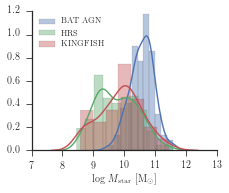

In [20]:
fig = plt.figure(figsize=(columnwidth, 3./4.*columnwidth))
sn.distplot(bat_casey['Mstar'].dropna(), label='BAT AGN')
sn.distplot(hrs_info['logMstart'].dropna(), label='HRS')
sn.distplot(kf_info['Mstar'][~kf_dwarfs].dropna(), label='KINGFISH')
plt.xlabel(r'$\log\,M_{\rm star}$ [M$_{\odot}$]')
plt.legend(loc='upper left')
sn.despine()
plt.savefig(figsave_dir+'stellar_mass_comp.pdf', bbox_inches='tight')